In [1]:
!pip install -q pydicom numpy matplotlib Pillow
import os
import cv2
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import optim
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
## self.data contains all patient directories where each index is: key "img" with all images, and key "age" with age
class NewDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.patient_dirs = os.listdir(root_dir)
    self.transform = transform
    self.num_images = 30
    self.data = []
    for i, dir in enumerate(self.patient_dirs):
      subdir_path = os.path.join(root_dir, dir)
      dicom_files = os.listdir(subdir_path)
      random.shuffle(dicom_files)
      dicom_arr = np.zeros(len(dicom_files))
      patient_data = {"imgs": [], "age": 0}
      age = None
      for j, dicom_file in enumerate(dicom_files):
        dicom_name = os.path.join(subdir_path, dicom_file)
        dcm = pydicom.dcmread(dicom_name, force=True)
        img = dcm.pixel_array
        img -= np.min(img)      # Normalize image
        img = img / np.max(img) #
        if len(patient_data["imgs"]) == 0:
          patient_data["imgs"] = np.array(img, dtype="float64")
        else:
          patient_data["imgs"] = np.dstack((patient_data["imgs"], img))
        if age is None:
          age = int(dcm.PatientAge[:-1])
          patient_data["age"] = age
        if j == self.num_images - 1: # use only 30 images
          break
      self.data.append(patient_data)

  def __len__(self):
    return len(self.patient_dirs)

  def __getitem__(self, idx):
    patient_data = self.data[idx]
    imgs = patient_data["imgs"]
    age = patient_data["age"]

    return imgs, age

In [4]:
patient_dataset = NewDataset(root_dir="/content/drive/MyDrive/Kaggle_Proj/Experiment_Dataset/")

In [5]:
for sample in patient_dataset:
  X, y = sample
  print(X.shape)
  print(y)
  break

(512, 512, 30)
78


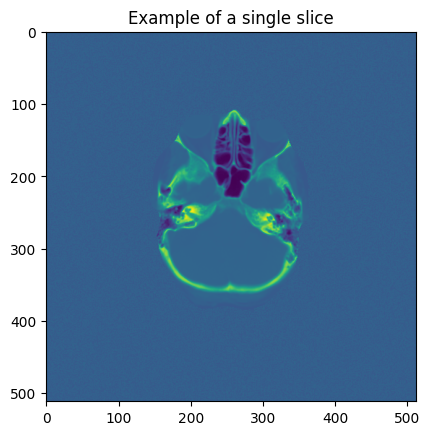

In [6]:
# Plot sample slice
plt.imshow(X[:, :, 0])
plt.title("Example of a single slice")
plt.show()

In [7]:
train_set, test_set = random_split(patient_dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1)
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 18, Test set size: 4


In [8]:
for X, y in train_dataloader:
  print(X.shape)
  print(y)
  break

torch.Size([1, 512, 512, 30])
tensor([41])


In [9]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = " cpu"
print(f"Using device: {device}")

Using device: cuda


In [35]:
import torch.nn as nn
# --- Model Architecture ---
#
# CNN Model for age prediction task
# Input: Tensors representing images
# Output: Integer representing age
#
# We use a number of convolutional layers to downsample the images
# Then we flatten the outputs from convolutional layers and run them
# through a number of dense layers to finally get a single number as output
#
torch.set_default_dtype(torch.float64)

class CNN_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.img_size = 512
    self.channels = 30
    self.hidden_units = 32
    self.convolutional_layer = nn.Sequential(
        nn.Conv2d(in_channels=self.channels, out_channels=self.hidden_units, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=self.hidden_units, out_channels=self.hidden_units, kernel_size=3, stride=2, padding=1),
    )
    self.dense_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.hidden_units*64*64, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )


  def forward(self, x):
    x = x.permute(0, 3, 1, 2)
    x = self.convolutional_layer(x)
    x = self.dense_layer(x)
    return x

model = CNN_model()
model.to(device)

CNN_model(
  (convolutional_layer): Sequential(
    (0): Conv2d(30, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (dense_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [12]:
for X, y in train_dataloader:
  X, y = X.to(device), y.to(device)
  print(f"Input format: {X.shape}")
  print(f"Target format: {y}")
  out = model(X)
  print(f"Target shape: {y.shape}, Output shape: {out.shape}")
  break

Input format: torch.Size([1, 512, 512, 30])
Target format: tensor([88], device='cuda:0')
Target shape: torch.Size([1]), Output shape: torch.Size([1, 1])


In [36]:
# Training run
num_epochs = 100
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train():
  model.train()
  train_loss = 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    output = model(X)
    loss = loss_fn(output, y.unsqueeze(1))
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  return train_loss

def test():
  model.eval()
  test_loss = 0
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    test_loss += loss_fn(pred, y)
  test_loss /= len(test_dataloader)
  return test_loss

train_losses = []
test_losses = []
for epoch in range(num_epochs):
  train_loss = train()
  test_loss = test()
  train_losses.append(train_loss.detach().cpu())
  test_losses.append(test_loss.detach().cpu())
  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch + 1}, Training loss: {train_loss:.4f}, Test loss: {test_loss:.4f}")

Epoch: 10, Training loss: 20.8761, Test loss: 13.6885
Epoch: 20, Training loss: 6.7167, Test loss: 16.7201
Epoch: 30, Training loss: 4.3437, Test loss: 13.4725
Epoch: 40, Training loss: 6.5159, Test loss: 11.9694
Epoch: 50, Training loss: 3.4062, Test loss: 11.9029
Epoch: 60, Training loss: 6.4373, Test loss: 14.4642
Epoch: 70, Training loss: 3.8940, Test loss: 11.9915
Epoch: 80, Training loss: 7.6959, Test loss: 12.2162
Epoch: 90, Training loss: 4.8823, Test loss: 11.3104
Epoch: 100, Training loss: 3.5620, Test loss: 12.8707


In [37]:
for X, y in test_dataloader:
  X, y = X.to(device), y.to(device)
  out = model(X)
  print("Example prediction")
  print(f"Prediction: {out.item():.0f}, correct: {y.item()}")
  break

Example prediction
Prediction: 61, correct: 54


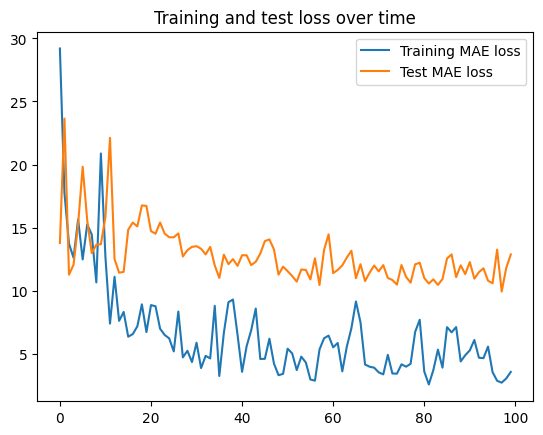

In [38]:
# Plot training and test losses
plt.plot(range(num_epochs), train_losses, label="Training MAE loss")
plt.plot(range(num_epochs), test_losses, label="Test MAE loss")
plt.title("Training and test loss over time")
plt.legend()
plt.show()